In [1]:
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm  # For showing progress bars
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchtext; torchtext.disable_torchtext_deprecation_warning()
from torchtext.datasets import IMDB
from torchtext.vocab import build_vocab_from_iterator
from torch.optim import lr_scheduler
import pandas as pd
from tabulate import tabulate
import random

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# Initialize stopwords and stemmer
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

### Text preprocessing functions
Text preprocessing in this code involves **normalizing the text** by converting it to **lowercase, removing URLs, non-word characters,** and extra spaces, as well as **removing punctuation, stopwords,** and applying stemming**. This preprocessing cleans and standardizes the text data, making it more suitable for the sentiment classification model.

Inspired from this Medium article: https://medium.com/@AMustafa4983/sentiment-analysis-on-imdb-movie-reviews-a-beginners-guide-d5136ec74e56


In [3]:
def remove_stopwords(text):
    words = text.split()
    filtered_sentence = ' '.join([word for word in words if word not in stop_words])
    return filtered_sentence

def normalize_text(text):
    text = text.lower()
    # Remove URLs
    text = re.sub('https?://\S+|www\.\S+', '', text)
    # Remove non-word characters and extra spaces
    text = re.sub('\\W', ' ', text)
    text = re.sub('\n', '', text)
    text = re.sub(' +', ' ', text)
    text = text.strip()
    return text


def remove_punctuation(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)


def stemming(text):
    words = text.split()
    stemmed_sentence = ' '.join([ps.stem(word) for word in words])
    return stemmed_sentence


# combining all 
def clean_text(text):
    text = text.lower()
    # Special character replacements
    text = text.replace(',', ' , ').replace('.', ' . ').replace('/', ' / ').replace('@', ' @ ')
    text = text.replace('#', ' # ').replace('?', ' ? ')
    # Apply other cleaning functions
    text = normalize_text(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text = stemming(text)
    return text

In [4]:
# Preprocessing the text data in the IMDB dataset
def preprocess_dataset(dataset):
    preprocessed_data = []
    for label, text in dataset:
        cleaned_text = clean_text(text)
        preprocessed_data.append((label, cleaned_text))
    return preprocessed_data

### Task and hardware used 
**Task**: The task is to build and evaluate text classification models for sentiment analysis using the IMDB dataset. We compare 2-layer and 1-layer MLP model performances on the test set, plot the loss curves and analyze errors on few test set samples.

**Hardware used**: Laptop GPU used for training - Nvidia GeForce RTX 3050

### Choosing IMDB dataset from TorchText.datasets
**IMDB Dataset**: This dataset is used for binary sentiment classification. It contains movie reviews labeled as positive or negative. In the code, the dataset is processed by applying text cleaning techniques such as normalization, removal of punctuation and stopwords, and stemming.



In [5]:
# Choosing IMDB dataset
train_iter = IMDB(split='train')
train_data = preprocess_dataset(train_iter)

# Use `train_data` for further tokenization and model training
train_data = preprocess_dataset(IMDB(split='train'))

C:\Users\ASUS\anaconda3\envs\nlp\lib\site-packages\torchdata\datapipes\__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()


#### Tokenization and creating vocabulary
Tokenization is performed using the **yield_tokens function**, and vocabulary is created with **build_vocab_from_iterator** to map each token to a numerical index. This numerical representation is then used to convert text into integer tokens for model training.

In [6]:
# Define a generator function to yield tokenized lines
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield text.split()

# Build vocabulary from the dataset (select top vocab_size words)
train_iter = IMDB(split='train')

vocab = build_vocab_from_iterator(yield_tokens(train_iter))

### Creating dataloader
The **encode_line** function converts text into integer tokens based on the vocabulary. The **collate_batch** function processes batches of text and labels by encoding the them into tensors, converting labels to '0' (negative) and '1' (positive) classes and adjusting offsets for variable-length sequences.

In [7]:
# Convert text into integer tokens
def encode_line(line):
    return [vocab[token] for token in line.split() if token in vocab]

In [8]:
# dataset loader and batching, code inspired using ChatGPT
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
        label_list.append(1 if int(_label) == 2 else 0)  # Convert label to 0 or 1
        processed_text = torch.tensor(encode_line(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = torch.cat(text_list)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    return label_list, text_list, offsets

In [9]:
train_iter = IMDB(split='train')
train_loader = DataLoader(list(train_iter), batch_size=8, shuffle=True, collate_fn=collate_batch)

test_iter = IMDB(split='test')
test_loader = DataLoader(list(test_iter), batch_size=8, shuffle=False, collate_fn=collate_batch)

## MLP with two fully connected layers

In [10]:
class MLP(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_class):
        super(MLP, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc1 = nn.Linear(embed_dim, hidden_dim)  # First fully connected layer (embed_dim -> hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_class)  # Second fully connected layer (hidden_dim -> num_class)
        self.dropout = nn.Dropout(0.1) 
        
    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        x = F.relu(self.fc1(embedded))  # Apply ReLU activation after fc1
        x = self.dropout(x)             # Apply dropout
        return self.fc2(x)              # returning output from fc2

## MLP with one FC layer

In [11]:
class MLP_one_layer(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(MLP_one_layer, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc1 = nn.Linear(embed_dim, num_class)  # Only 1 fully connected layer (embed_dim -> num_class)
        self.dropout = nn.Dropout(0.1) 
        
    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        x = F.relu(self.fc1(embedded))  # Apply ReLU activation after fc1
        x = self.dropout(x)             # Apply dropout
        return x                        # returning output from dropout

# Training and evaluation code

The **train_and_evaluate** function trains a model over multiple epochs, evaluates its performance on a test set, and tracks metrics like loss and accuracy, while saving the best-performing model. The **evaluate** function assesses the model's performance on the test set, computing average loss and accuracy.

In [12]:
# code inspired from ChatGPT
def evaluate(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for labels, texts, offsets in data_loader:
            labels = labels.to(device)
            texts = texts.to(device)
            offsets = offsets.to(device)
            
            output = model(texts, offsets)
            loss = criterion(output, labels)

            predicted_classes = output.argmax(dim=1)
            correct += (predicted_classes == labels).sum().item()
            total += labels.size(0)
            total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total * 100
    return avg_loss, accuracy

In [13]:
# code inspired from ChatGPT
def train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, epochs=5, save_path='best_model.pth'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    train_losses = []
    test_losses = []
    test_accuracies = []
    train_accuracies = []

    best_accuracy = 0.0  # Initialize to track the best accuracy
    best_loss = float('inf')  # Optionally track the best loss instead

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct_train = 0
        total_train = 0

        # Training loop with progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}", leave=False)

        for labels, texts, offsets in progress_bar:
            optimizer.zero_grad()

            labels = labels.to(device)
            texts = texts.to(device)
            offsets = offsets.to(device)

            output = model(texts, offsets)
            loss = criterion(output, labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            
            # Compute training accuracy
            _, predicted = torch.max(output, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

            progress_bar.set_postfix(loss=total_loss / len(train_loader))

        avg_train_loss = total_loss / len(train_loader)
        avg_train_accuracy = (correct_train / total_train) * 100
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_accuracy)

        # Evaluate the model on the test set after each epoch
        test_loss, test_accuracy = evaluate(model, test_loader, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

        # Save the model if test accuracy improves
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            torch.save(model.state_dict(), save_path)
            print(f"Best model saved at epoch {epoch + 1} with Test Accuracy: {test_accuracy:.2f}%")

    return train_losses, train_accuracies, test_losses, test_accuracies

In [14]:
# Function for plotting test set loss and accuracy curves
def plot_mlp_results(test_acc, test_loss, num_layer, inter_dim):
    epochs = range(1, len(test_loss) + 1)
    plt.figure(figsize=(12, 5))

    # Plot for Test Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, test_acc, label='Test Accuracy', marker='o')
    plt.title(f'Test Accuracy for: {num_layer} layer MLP, intermediate dim = {inter_dim}')  
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.legend()

    # Plot for Test Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, test_loss, label='Test Loss', color='red', marker='o')
    plt.title(f'Test Loss for: {num_layer} layer MLP, intermediate dim = {inter_dim}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

## Training with 2 layer MLP, with intermediate layer dim = 100

**Hyperparameters used:** 
1. Embedding Dimension: 2048
2. Hidden Dimension: 100
3. Number of Classes: 2 
4. Learning Rate: 0.001
5. Optimizer: Stochastic Gradient Descent (SGD)
6. Epochs: 40
7. Learning rate: 0.001

**Why It Works Well:**
The choice of a high embedding dimension (2048) allows the model to capture rich textual features, while a moderate hidden dimension (100) provides a balance between model capacity and generalization. Also most of the reviews have large paragraphs with multiple sentences, so a high embedding dimension seems appropriate. The SGD optimizer with a learning rate of 0.001 ensures stable convergence, and evaluating the model over 40 epochs allows adequate training to optimize performance.

In [14]:
# Initialize model, optimizer, and loss function
vocab_size = len(vocab)
embed_dim = 2048
hidden_dim = 100
num_class = 2  # Positive or Negative

# Initialize model
model_l2_dim_100 = MLP(vocab_size, embed_dim, hidden_dim, num_class)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Check if CUDA is available
model_l2_dim_100.to(device)

MLP(
  (embedding): EmbeddingBag(280617, 2048, mode='mean')
  (fc1): Linear(in_features=2048, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [16]:
sgd_optimizer = optim.SGD(model_l2_dim_100.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()
train_loss_l2_dim_100, train_acc_l2_dim_100, test_loss_l2_dim_100, test_acc_l2_dim_100 = train_and_evaluate(
    model_l2_dim_100, train_loader, test_loader, sgd_optimizer, criterion, epochs=40, save_path='best_model_l2_dim_100.pth'
)

Epoch 1/40, Train Loss: 0.6874, Train Accuracy: 57.16%, Test Loss: 0.6809, Test Accuracy: 61.33%
Best model saved at epoch 1 with Test Accuracy: 61.33%


Epoch 2/40, Train Loss: 0.6735, Train Accuracy: 63.07%, Test Loss: 0.6646, Test Accuracy: 65.38%
Best model saved at epoch 2 with Test Accuracy: 65.38%


Epoch 3/40, Train Loss: 0.6549, Train Accuracy: 65.59%, Test Loss: 0.6431, Test Accuracy: 66.79%
Best model saved at epoch 3 with Test Accuracy: 66.79%


Epoch 4/40, Train Loss: 0.6328, Train Accuracy: 67.40%, Test Loss: 0.6198, Test Accuracy: 68.37%
Best model saved at epoch 4 with Test Accuracy: 68.37%


Epoch 5/40, Train Loss: 0.6101, Train Accuracy: 69.38%, Test Loss: 0.5965, Test Accuracy: 70.17%
Best model saved at epoch 5 with Test Accuracy: 70.17%


Epoch 6/40, Train Loss: 0.5875, Train Accuracy: 71.23%, Test Loss: 0.5744, Test Accuracy: 71.90%
Best model saved at epoch 6 with Test Accuracy: 71.90%


Epoch 7/40, Train Loss: 0.5651, Train Accuracy: 72.84%, Test Loss: 0.5520, Test Accuracy: 73.81%
Best model saved at epoch 7 with Test Accuracy: 73.81%


Epoch 8/40, Train Loss: 0.5449, Train Accuracy: 74.30%, Test Loss: 0.5331, Test Accuracy: 75.09%
Best model saved at epoch 8 with Test Accuracy: 75.09%


Epoch 9/40, Train Loss: 0.5262, Train Accuracy: 75.41%, Test Loss: 0.5158, Test Accuracy: 76.04%
Best model saved at epoch 9 with Test Accuracy: 76.04%


Epoch 10/40, Train Loss: 0.5096, Train Accuracy: 76.71%, Test Loss: 0.5033, Test Accuracy: 76.80%
Best model saved at epoch 10 with Test Accuracy: 76.80%


Epoch 11/40, Train Loss: 0.4961, Train Accuracy: 77.38%, Test Loss: 0.4890, Test Accuracy: 77.64%
Best model saved at epoch 11 with Test Accuracy: 77.64%


Epoch 12/40, Train Loss: 0.4834, Train Accuracy: 78.15%, Test Loss: 0.4783, Test Accuracy: 78.21%
Best model saved at epoch 12 with Test Accuracy: 78.21%


Epoch 13/40, Train Loss: 0.4719, Train Accuracy: 78.78%, Test Loss: 0.4701, Test Accuracy: 78.58%
Best model saved at epoch 13 with Test Accuracy: 78.58%


Epoch 14/40, Train Loss: 0.4631, Train Accuracy: 79.33%, Test Loss: 0.4629, Test Accuracy: 78.84%
Best model saved at epoch 14 with Test Accuracy: 78.84%


Epoch 15/40, Train Loss: 0.4543, Train Accuracy: 79.86%, Test Loss: 0.4552, Test Accuracy: 79.34%
Best model saved at epoch 15 with Test Accuracy: 79.34%


Epoch 16/40, Train Loss: 0.4476, Train Accuracy: 79.92%, Test Loss: 0.4489, Test Accuracy: 79.54%
Best model saved at epoch 16 with Test Accuracy: 79.54%


Epoch 17/40, Train Loss: 0.4403, Train Accuracy: 80.61%, Test Loss: 0.4440, Test Accuracy: 79.88%
Best model saved at epoch 17 with Test Accuracy: 79.88%


Epoch 18/40, Train Loss: 0.4335, Train Accuracy: 80.83%, Test Loss: 0.4395, Test Accuracy: 80.17%
Best model saved at epoch 18 with Test Accuracy: 80.17%


Epoch 19/40, Train Loss: 0.4275, Train Accuracy: 80.97%, Test Loss: 0.4349, Test Accuracy: 80.32%
Best model saved at epoch 19 with Test Accuracy: 80.32%


Epoch 20/40, Train Loss: 0.4223, Train Accuracy: 81.39%, Test Loss: 0.4343, Test Accuracy: 80.38%
Best model saved at epoch 20 with Test Accuracy: 80.38%


Epoch 21/40, Train Loss: 0.4170, Train Accuracy: 81.67%, Test Loss: 0.4278, Test Accuracy: 80.72%
Best model saved at epoch 21 with Test Accuracy: 80.72%


Epoch 22/40, Train Loss: 0.4135, Train Accuracy: 81.84%, Test Loss: 0.4265, Test Accuracy: 80.66%


Epoch 23/40, Train Loss: 0.4085, Train Accuracy: 82.02%, Test Loss: 0.4230, Test Accuracy: 80.84%
Best model saved at epoch 23 with Test Accuracy: 80.84%


Epoch 24/40, Train Loss: 0.4053, Train Accuracy: 82.14%, Test Loss: 0.4204, Test Accuracy: 80.88%
Best model saved at epoch 24 with Test Accuracy: 80.88%


Epoch 25/40, Train Loss: 0.4008, Train Accuracy: 82.30%, Test Loss: 0.4217, Test Accuracy: 80.71%


Epoch 26/40, Train Loss: 0.3973, Train Accuracy: 82.68%, Test Loss: 0.4178, Test Accuracy: 81.15%
Best model saved at epoch 26 with Test Accuracy: 81.15%


Epoch 27/40, Train Loss: 0.3944, Train Accuracy: 82.71%, Test Loss: 0.4147, Test Accuracy: 81.27%
Best model saved at epoch 27 with Test Accuracy: 81.27%


Epoch 28/40, Train Loss: 0.3915, Train Accuracy: 82.91%, Test Loss: 0.4135, Test Accuracy: 81.40%
Best model saved at epoch 28 with Test Accuracy: 81.40%


Epoch 29/40, Train Loss: 0.3900, Train Accuracy: 82.99%, Test Loss: 0.4122, Test Accuracy: 81.39%


Epoch 30/40, Train Loss: 0.3866, Train Accuracy: 83.09%, Test Loss: 0.4107, Test Accuracy: 81.41%
Best model saved at epoch 30 with Test Accuracy: 81.41%


Epoch 31/40, Train Loss: 0.3847, Train Accuracy: 83.15%, Test Loss: 0.4097, Test Accuracy: 81.54%
Best model saved at epoch 31 with Test Accuracy: 81.54%


Epoch 32/40, Train Loss: 0.3808, Train Accuracy: 83.30%, Test Loss: 0.4092, Test Accuracy: 81.42%


Epoch 33/40, Train Loss: 0.3793, Train Accuracy: 83.51%, Test Loss: 0.4089, Test Accuracy: 81.40%


Epoch 34/40, Train Loss: 0.3762, Train Accuracy: 83.42%, Test Loss: 0.4074, Test Accuracy: 81.56%
Best model saved at epoch 34 with Test Accuracy: 81.56%


Epoch 35/40, Train Loss: 0.3743, Train Accuracy: 83.70%, Test Loss: 0.4125, Test Accuracy: 81.09%


Epoch 36/40, Train Loss: 0.3732, Train Accuracy: 83.67%, Test Loss: 0.4138, Test Accuracy: 81.29%


Epoch 37/40, Train Loss: 0.3719, Train Accuracy: 83.74%, Test Loss: 0.4064, Test Accuracy: 81.61%
Best model saved at epoch 37 with Test Accuracy: 81.61%


Epoch 38/40, Train Loss: 0.3696, Train Accuracy: 83.82%, Test Loss: 0.4054, Test Accuracy: 81.66%
Best model saved at epoch 38 with Test Accuracy: 81.66%


Epoch 39/40, Train Loss: 0.3673, Train Accuracy: 84.03%, Test Loss: 0.4051, Test Accuracy: 81.71%
Best model saved at epoch 39 with Test Accuracy: 81.71%


Epoch 40/40, Train Loss: 0.3652, Train Accuracy: 83.91%, Test Loss: 0.4043, Test Accuracy: 81.76%
Best model saved at epoch 40 with Test Accuracy: 81.76%


## Test loss and accuracy curves for 2 layer MLP, intermediate dim = 100

#### Best Test set accuracy: 81.76%
Achieved at epoch 40 using **2 layer MLP** and **intermediate layer dimension = 100**

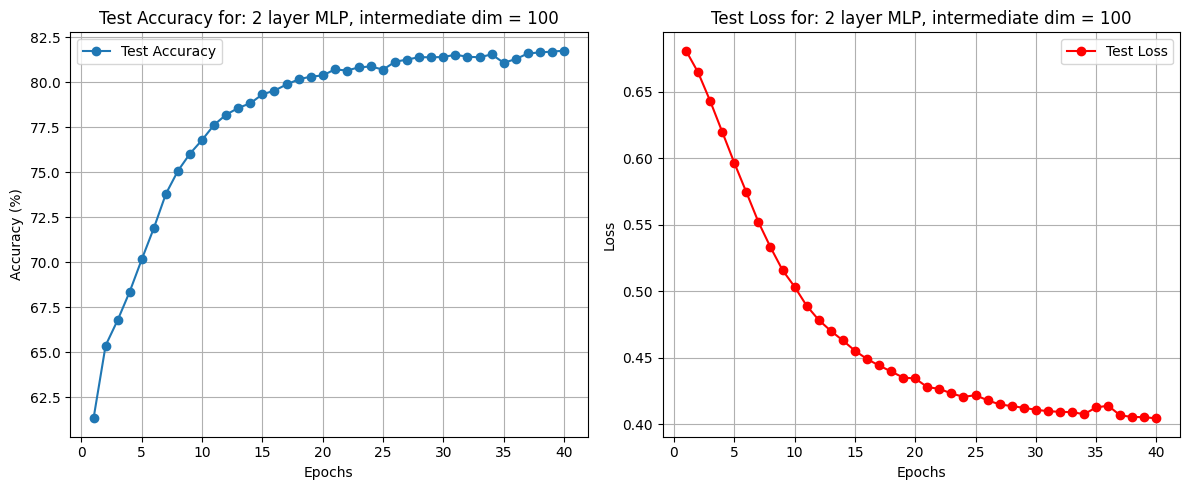

In [20]:
plot_mlp_results(test_acc_l2_dim_100, test_loss_l2_dim_100, 2, 100)

## Training with 2 layer MLP, with intermediate layer dim = 200

**Hyperparameters used:** 
1. Embedding Dimension: 2048
2. Hidden Dimension: **200**
3. Number of Classes: 2 
4. Learning Rate: 0.001
5. Optimizer: Stochastic Gradient Descent (SGD)
6. Epochs: 40
7. Learning rate: 0.001

In [16]:
# Initialize model, optimizer, and loss function
vocab_size = len(vocab)
embed_dim = 2048
hidden_dim = 200
num_class = 2  # Positive or Negative

# Initialize model
model_l2_dim_200 = MLP(vocab_size, embed_dim, hidden_dim, num_class)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Check if CUDA is available
model_l2_dim_200.to(device)

MLP(
  (embedding): EmbeddingBag(280617, 2048, mode='mean')
  (fc1): Linear(in_features=2048, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=2, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [18]:
sgd_optimizer_2 = optim.SGD(model_l2_dim_200.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()
train_loss_l2_dim_200, train_acc_l2_dim_200, test_loss_l2_dim_200, test_acc_l2_dim_200 = train_and_evaluate(
    model_l2_dim_200, train_loader, test_loader, sgd_optimizer_2, criterion, epochs=40, save_path='best_model_l2_dim_200.pth'
)

Epoch 1/40, Train Loss: 0.6897, Train Accuracy: 55.00%, Test Loss: 0.6836, Test Accuracy: 63.41%
Best model saved at epoch 1 with Test Accuracy: 63.41%


Epoch 2/40, Train Loss: 0.6759, Train Accuracy: 64.09%, Test Loss: 0.6671, Test Accuracy: 63.64%
Best model saved at epoch 2 with Test Accuracy: 63.64%


Epoch 3/40, Train Loss: 0.6568, Train Accuracy: 65.32%, Test Loss: 0.6456, Test Accuracy: 66.38%
Best model saved at epoch 3 with Test Accuracy: 66.38%


Epoch 4/40, Train Loss: 0.6344, Train Accuracy: 67.34%, Test Loss: 0.6228, Test Accuracy: 67.98%
Best model saved at epoch 4 with Test Accuracy: 67.98%


Epoch 5/40, Train Loss: 0.6126, Train Accuracy: 69.00%, Test Loss: 0.6007, Test Accuracy: 69.69%
Best model saved at epoch 5 with Test Accuracy: 69.69%


Epoch 6/40, Train Loss: 0.5912, Train Accuracy: 70.63%, Test Loss: 0.5790, Test Accuracy: 71.55%
Best model saved at epoch 6 with Test Accuracy: 71.55%


Epoch 7/40, Train Loss: 0.5705, Train Accuracy: 72.28%, Test Loss: 0.5589, Test Accuracy: 73.06%
Best model saved at epoch 7 with Test Accuracy: 73.06%


Epoch 8/40, Train Loss: 0.5514, Train Accuracy: 73.64%, Test Loss: 0.5395, Test Accuracy: 74.47%
Best model saved at epoch 8 with Test Accuracy: 74.47%


Epoch 9/40, Train Loss: 0.5335, Train Accuracy: 74.96%, Test Loss: 0.5232, Test Accuracy: 75.31%
Best model saved at epoch 9 with Test Accuracy: 75.31%


Epoch 10/40, Train Loss: 0.5167, Train Accuracy: 76.10%, Test Loss: 0.5115, Test Accuracy: 75.72%
Best model saved at epoch 10 with Test Accuracy: 75.72%


Epoch 11/40, Train Loss: 0.5023, Train Accuracy: 76.82%, Test Loss: 0.4942, Test Accuracy: 77.11%
Best model saved at epoch 11 with Test Accuracy: 77.11%


Epoch 12/40, Train Loss: 0.4896, Train Accuracy: 77.64%, Test Loss: 0.4835, Test Accuracy: 77.68%
Best model saved at epoch 12 with Test Accuracy: 77.68%


Epoch 13/40, Train Loss: 0.4777, Train Accuracy: 78.47%, Test Loss: 0.4728, Test Accuracy: 78.26%
Best model saved at epoch 13 with Test Accuracy: 78.26%


Epoch 14/40, Train Loss: 0.4674, Train Accuracy: 78.88%, Test Loss: 0.4645, Test Accuracy: 78.71%
Best model saved at epoch 14 with Test Accuracy: 78.71%


Epoch 15/40, Train Loss: 0.4593, Train Accuracy: 79.26%, Test Loss: 0.4567, Test Accuracy: 79.14%
Best model saved at epoch 15 with Test Accuracy: 79.14%


Epoch 16/40, Train Loss: 0.4509, Train Accuracy: 79.56%, Test Loss: 0.4505, Test Accuracy: 79.42%
Best model saved at epoch 16 with Test Accuracy: 79.42%


Epoch 17/40, Train Loss: 0.4443, Train Accuracy: 80.07%, Test Loss: 0.4447, Test Accuracy: 79.80%
Best model saved at epoch 17 with Test Accuracy: 79.80%


Epoch 18/40, Train Loss: 0.4377, Train Accuracy: 80.35%, Test Loss: 0.4398, Test Accuracy: 79.90%
Best model saved at epoch 18 with Test Accuracy: 79.90%


Epoch 19/40, Train Loss: 0.4315, Train Accuracy: 81.02%, Test Loss: 0.4375, Test Accuracy: 80.22%
Best model saved at epoch 19 with Test Accuracy: 80.22%


Epoch 20/40, Train Loss: 0.4255, Train Accuracy: 81.14%, Test Loss: 0.4317, Test Accuracy: 80.28%
Best model saved at epoch 20 with Test Accuracy: 80.28%


Epoch 21/40, Train Loss: 0.4214, Train Accuracy: 81.26%, Test Loss: 0.4336, Test Accuracy: 80.33%
Best model saved at epoch 21 with Test Accuracy: 80.33%


Epoch 22/40, Train Loss: 0.4161, Train Accuracy: 81.56%, Test Loss: 0.4268, Test Accuracy: 80.76%
Best model saved at epoch 22 with Test Accuracy: 80.76%


Epoch 23/40, Train Loss: 0.4125, Train Accuracy: 81.55%, Test Loss: 0.4223, Test Accuracy: 80.78%
Best model saved at epoch 23 with Test Accuracy: 80.78%


Epoch 24/40, Train Loss: 0.4093, Train Accuracy: 81.86%, Test Loss: 0.4201, Test Accuracy: 80.91%
Best model saved at epoch 24 with Test Accuracy: 80.91%


Epoch 25/40, Train Loss: 0.4039, Train Accuracy: 82.07%, Test Loss: 0.4201, Test Accuracy: 81.09%
Best model saved at epoch 25 with Test Accuracy: 81.09%


Epoch 26/40, Train Loss: 0.4014, Train Accuracy: 82.37%, Test Loss: 0.4175, Test Accuracy: 81.28%
Best model saved at epoch 26 with Test Accuracy: 81.28%


Epoch 27/40, Train Loss: 0.3973, Train Accuracy: 82.37%, Test Loss: 0.4182, Test Accuracy: 81.11%


Epoch 28/40, Train Loss: 0.3945, Train Accuracy: 82.39%, Test Loss: 0.4126, Test Accuracy: 81.44%
Best model saved at epoch 28 with Test Accuracy: 81.44%


Epoch 29/40, Train Loss: 0.3923, Train Accuracy: 82.72%, Test Loss: 0.4146, Test Accuracy: 81.28%


Epoch 30/40, Train Loss: 0.3889, Train Accuracy: 82.68%, Test Loss: 0.4117, Test Accuracy: 81.43%


Epoch 31/40, Train Loss: 0.3867, Train Accuracy: 82.84%, Test Loss: 0.4092, Test Accuracy: 81.65%
Best model saved at epoch 31 with Test Accuracy: 81.65%


Epoch 32/40, Train Loss: 0.3839, Train Accuracy: 83.08%, Test Loss: 0.4083, Test Accuracy: 81.64%


Epoch 33/40, Train Loss: 0.3818, Train Accuracy: 82.96%, Test Loss: 0.4126, Test Accuracy: 81.41%


Epoch 34/40, Train Loss: 0.3801, Train Accuracy: 83.14%, Test Loss: 0.4082, Test Accuracy: 81.57%


Epoch 35/40, Train Loss: 0.3776, Train Accuracy: 83.36%, Test Loss: 0.4070, Test Accuracy: 81.72%
Best model saved at epoch 35 with Test Accuracy: 81.72%


Epoch 36/40, Train Loss: 0.3753, Train Accuracy: 83.52%, Test Loss: 0.4044, Test Accuracy: 81.91%
Best model saved at epoch 36 with Test Accuracy: 81.91%


Epoch 37/40, Train Loss: 0.3733, Train Accuracy: 83.58%, Test Loss: 0.4060, Test Accuracy: 81.61%


Epoch 38/40, Train Loss: 0.3710, Train Accuracy: 83.56%, Test Loss: 0.4036, Test Accuracy: 81.90%


Epoch 39/40, Train Loss: 0.3689, Train Accuracy: 83.71%, Test Loss: 0.4067, Test Accuracy: 81.67%


Epoch 40/40, Train Loss: 0.3659, Train Accuracy: 84.03%, Test Loss: 0.4059, Test Accuracy: 81.68%


## Test accuracy and test accuracy curves for 2 layer MLP, intermediate dim = 200

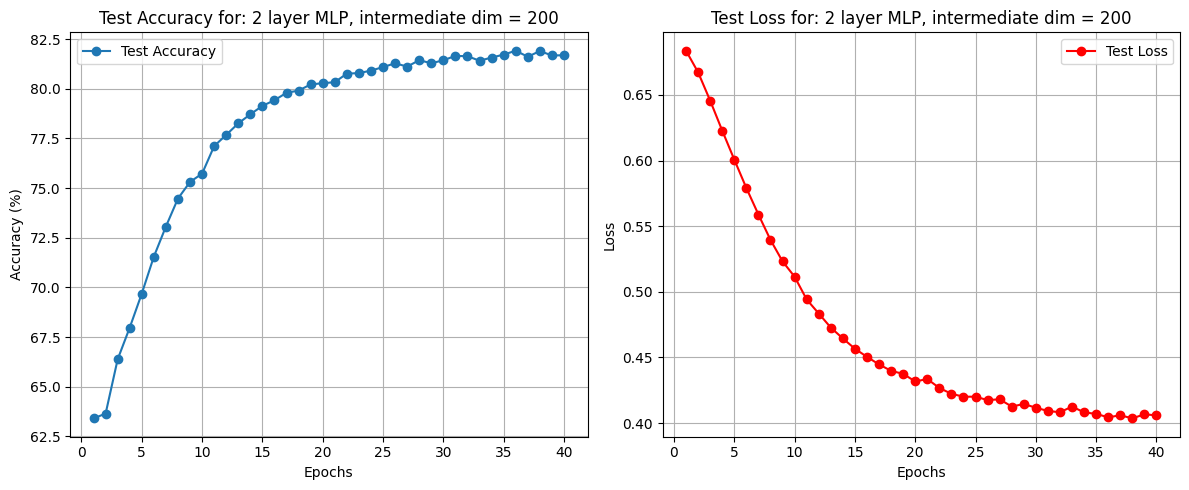

In [19]:
plot_mlp_results(test_acc_l2_dim_200, test_loss_l2_dim_200, 2, 200)

#### Best Test set accuracy: 81.91%
Achieved at epoch 36 using **2 layer MLP** and **intermediate layer dimension = 200**


## Training with 1 layer MLP

**Hyperparameters used:** 
1. Embedding Dimension: 2048
2. Number of Classes: 2 
3. Learning Rate: 0.001
4. Optimizer: Stochastic Gradient Descent (SGD)
5. Epochs: 40
6. Learning rate: 0.001

In [15]:
# Initialize model, optimizer, and loss function
vocab_size = len(vocab)
embed_dim = 2048
num_class = 2  # Positive or Negative

# Initialize model
model_l1 = MLP_one_layer(vocab_size, embed_dim, num_class)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Check if CUDA is available
model_l1.to(device)

MLP_one_layer(
  (embedding): EmbeddingBag(280617, 2048, mode='mean')
  (fc1): Linear(in_features=2048, out_features=2, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [16]:
sgd_optimizer_3 = optim.SGD(model_l1.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()
train_loss_l1, train_acc_l1, test_loss_l1, test_acc_l1 = train_and_evaluate(
    model_l1, train_loader, test_loader, sgd_optimizer_3, criterion, epochs=40, save_path='best_model_l1.pth'
)

Epoch 1/40, Train Loss: 0.6782, Train Accuracy: 57.44%, Test Loss: 0.6573, Test Accuracy: 65.93%
Best model saved at epoch 1 with Test Accuracy: 65.93%


Epoch 2/40, Train Loss: 0.6478, Train Accuracy: 63.75%, Test Loss: 0.6329, Test Accuracy: 68.42%
Best model saved at epoch 2 with Test Accuracy: 68.42%


Epoch 3/40, Train Loss: 0.6287, Train Accuracy: 66.11%, Test Loss: 0.6160, Test Accuracy: 70.14%
Best model saved at epoch 3 with Test Accuracy: 70.14%


Epoch 4/40, Train Loss: 0.6165, Train Accuracy: 67.05%, Test Loss: 0.6033, Test Accuracy: 71.18%
Best model saved at epoch 4 with Test Accuracy: 71.18%


Epoch 5/40, Train Loss: 0.6052, Train Accuracy: 68.30%, Test Loss: 0.5924, Test Accuracy: 72.41%
Best model saved at epoch 5 with Test Accuracy: 72.41%


Epoch 6/40, Train Loss: 0.5958, Train Accuracy: 69.01%, Test Loss: 0.5823, Test Accuracy: 73.09%
Best model saved at epoch 6 with Test Accuracy: 73.09%


Epoch 7/40, Train Loss: 0.5869, Train Accuracy: 70.09%, Test Loss: 0.5745, Test Accuracy: 73.50%
Best model saved at epoch 7 with Test Accuracy: 73.50%


Epoch 8/40, Train Loss: 0.5795, Train Accuracy: 70.58%, Test Loss: 0.5668, Test Accuracy: 74.32%
Best model saved at epoch 8 with Test Accuracy: 74.32%


Epoch 9/40, Train Loss: 0.5738, Train Accuracy: 70.76%, Test Loss: 0.5608, Test Accuracy: 74.84%
Best model saved at epoch 9 with Test Accuracy: 74.84%


Epoch 10/40, Train Loss: 0.5672, Train Accuracy: 71.56%, Test Loss: 0.5542, Test Accuracy: 75.04%
Best model saved at epoch 10 with Test Accuracy: 75.04%


Epoch 11/40, Train Loss: 0.5624, Train Accuracy: 71.55%, Test Loss: 0.5492, Test Accuracy: 75.59%
Best model saved at epoch 11 with Test Accuracy: 75.59%


Epoch 12/40, Train Loss: 0.5579, Train Accuracy: 71.86%, Test Loss: 0.5444, Test Accuracy: 75.80%
Best model saved at epoch 12 with Test Accuracy: 75.80%


Epoch 13/40, Train Loss: 0.5535, Train Accuracy: 72.06%, Test Loss: 0.5401, Test Accuracy: 76.12%
Best model saved at epoch 13 with Test Accuracy: 76.12%


Epoch 14/40, Train Loss: 0.5492, Train Accuracy: 72.34%, Test Loss: 0.5361, Test Accuracy: 76.38%
Best model saved at epoch 14 with Test Accuracy: 76.38%


Epoch 15/40, Train Loss: 0.5454, Train Accuracy: 72.75%, Test Loss: 0.5313, Test Accuracy: 76.64%
Best model saved at epoch 15 with Test Accuracy: 76.64%


Epoch 16/40, Train Loss: 0.5416, Train Accuracy: 73.07%, Test Loss: 0.5283, Test Accuracy: 76.81%
Best model saved at epoch 16 with Test Accuracy: 76.81%


Epoch 17/40, Train Loss: 0.5387, Train Accuracy: 73.07%, Test Loss: 0.5247, Test Accuracy: 77.01%
Best model saved at epoch 17 with Test Accuracy: 77.01%


Epoch 18/40, Train Loss: 0.5349, Train Accuracy: 73.37%, Test Loss: 0.5218, Test Accuracy: 77.16%
Best model saved at epoch 18 with Test Accuracy: 77.16%


Epoch 19/40, Train Loss: 0.5322, Train Accuracy: 73.49%, Test Loss: 0.5186, Test Accuracy: 77.23%
Best model saved at epoch 19 with Test Accuracy: 77.23%


Epoch 20/40, Train Loss: 0.5303, Train Accuracy: 73.53%, Test Loss: 0.5153, Test Accuracy: 77.47%
Best model saved at epoch 20 with Test Accuracy: 77.47%


Epoch 21/40, Train Loss: 0.5271, Train Accuracy: 73.66%, Test Loss: 0.5134, Test Accuracy: 77.62%
Best model saved at epoch 21 with Test Accuracy: 77.62%


Epoch 22/40, Train Loss: 0.5235, Train Accuracy: 74.27%, Test Loss: 0.5102, Test Accuracy: 77.77%
Best model saved at epoch 22 with Test Accuracy: 77.77%


Epoch 23/40, Train Loss: 0.5224, Train Accuracy: 74.07%, Test Loss: 0.5085, Test Accuracy: 77.80%
Best model saved at epoch 23 with Test Accuracy: 77.80%


Epoch 24/40, Train Loss: 0.5191, Train Accuracy: 74.09%, Test Loss: 0.5059, Test Accuracy: 77.89%
Best model saved at epoch 24 with Test Accuracy: 77.89%


Epoch 25/40, Train Loss: 0.5191, Train Accuracy: 74.06%, Test Loss: 0.5041, Test Accuracy: 77.98%
Best model saved at epoch 25 with Test Accuracy: 77.98%


Epoch 26/40, Train Loss: 0.5156, Train Accuracy: 74.20%, Test Loss: 0.5017, Test Accuracy: 78.02%
Best model saved at epoch 26 with Test Accuracy: 78.02%


Epoch 27/40, Train Loss: 0.5137, Train Accuracy: 74.33%, Test Loss: 0.4994, Test Accuracy: 78.36%
Best model saved at epoch 27 with Test Accuracy: 78.36%


Epoch 28/40, Train Loss: 0.5114, Train Accuracy: 74.67%, Test Loss: 0.4975, Test Accuracy: 78.34%


Epoch 29/40, Train Loss: 0.5099, Train Accuracy: 74.61%, Test Loss: 0.4963, Test Accuracy: 78.46%
Best model saved at epoch 29 with Test Accuracy: 78.46%


Epoch 30/40, Train Loss: 0.5082, Train Accuracy: 74.69%, Test Loss: 0.4943, Test Accuracy: 78.60%
Best model saved at epoch 30 with Test Accuracy: 78.60%


Epoch 31/40, Train Loss: 0.5053, Train Accuracy: 75.13%, Test Loss: 0.4925, Test Accuracy: 78.68%
Best model saved at epoch 31 with Test Accuracy: 78.68%


Epoch 32/40, Train Loss: 0.5036, Train Accuracy: 75.26%, Test Loss: 0.4906, Test Accuracy: 78.74%
Best model saved at epoch 32 with Test Accuracy: 78.74%


Epoch 33/40, Train Loss: 0.5059, Train Accuracy: 74.85%, Test Loss: 0.4894, Test Accuracy: 78.80%
Best model saved at epoch 33 with Test Accuracy: 78.80%


Epoch 34/40, Train Loss: 0.5016, Train Accuracy: 75.33%, Test Loss: 0.4880, Test Accuracy: 78.82%
Best model saved at epoch 34 with Test Accuracy: 78.82%


Epoch 35/40, Train Loss: 0.5008, Train Accuracy: 75.16%, Test Loss: 0.4862, Test Accuracy: 78.93%
Best model saved at epoch 35 with Test Accuracy: 78.93%


Epoch 36/40, Train Loss: 0.4966, Train Accuracy: 75.67%, Test Loss: 0.4851, Test Accuracy: 78.98%
Best model saved at epoch 36 with Test Accuracy: 78.98%


Epoch 37/40, Train Loss: 0.4957, Train Accuracy: 75.64%, Test Loss: 0.4835, Test Accuracy: 78.92%


Epoch 38/40, Train Loss: 0.4950, Train Accuracy: 75.67%, Test Loss: 0.4816, Test Accuracy: 79.09%
Best model saved at epoch 38 with Test Accuracy: 79.09%


Epoch 39/40, Train Loss: 0.4939, Train Accuracy: 75.67%, Test Loss: 0.4806, Test Accuracy: 79.14%
Best model saved at epoch 39 with Test Accuracy: 79.14%


Epoch 40/40, Train Loss: 0.4911, Train Accuracy: 75.98%, Test Loss: 0.4793, Test Accuracy: 79.13%


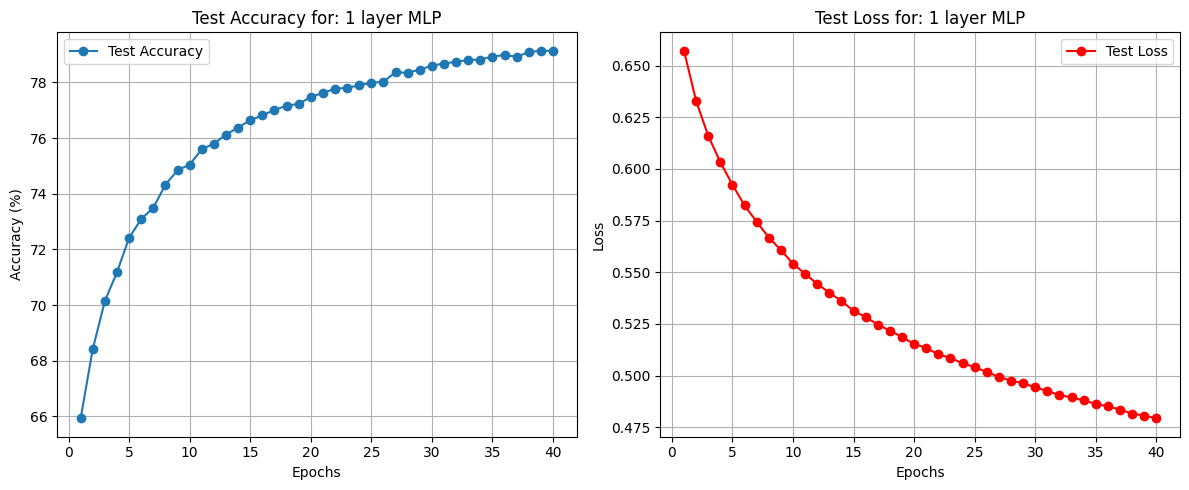

In [17]:
epochs = range(1, len(test_loss_l1) + 1)
plt.figure(figsize=(12, 5))

# Plot for Test Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, test_acc_l1, label='Test Accuracy', marker='o')
plt.title('Test Accuracy for: 1 layer MLP')  
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

# Plot for Test Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, test_loss_l1, label='Test Loss', color='red', marker='o')
plt.title('Test Loss for: 1 layer MLP')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

#### Best Test set accuracy with 1 layer MLP: 79.14%
Achieved at epoch 39

#### Q1: On the test set, what is the accuracy? Please draw a graph of test performance at each epoch of training.

List of test set accuracies achieved:
1. MLP with 2 layers, intermediate dim = 100 :**81.76%**
2. MLP with 2 layers, intermediate dim = 200 :**81.91%**
3. MLP with 1 layer :**79.14%**

Graphs of test loss and accuracy across 40 epochs have been plotted for all 3 models above.

#### Q2: What is the performance (i.e., accuracy on the test set) of a two-layer MLP compared to a singlelayer MLP?

Comparing the test set performance results of 2-layer MLPs and single-layer MLP in the **table below**:

In [18]:
# comparison of 2-layer MLPs and single-layer MLP
data_comparison = {
    'Model': ['Single-Layer MLP', '2-Layer MLP (intermediate dim=100)', '2-Layer MLP (intermediate dim=200)'],
    'Test Accuracy (%)': [79.14, 81.76, 81.91],
    'Accuracy Drop w.r.t Single-Layer MLP(%)': ["-", 81.76-79.14, 81.91-79.14]
}

df_comparison = pd.DataFrame(data_comparison)

print(tabulate(df_comparison, headers='keys', tablefmt='fancy_grid', showindex=False))


╒════════════════════════════════════╤═════════════════════╤═══════════════════════════════════════════╕
│ Model                              │   Test Accuracy (%) │ Accuracy Drop w.r.t Single-Layer MLP(%)   │
╞════════════════════════════════════╪═════════════════════╪═══════════════════════════════════════════╡
│ Single-Layer MLP                   │               79.14 │ -                                         │
├────────────────────────────────────┼─────────────────────┼───────────────────────────────────────────┤
│ 2-Layer MLP (intermediate dim=100) │               81.76 │ 2.6200000000000045                        │
├────────────────────────────────────┼─────────────────────┼───────────────────────────────────────────┤
│ 2-Layer MLP (intermediate dim=200) │               81.91 │ 2.769999999999996                         │
╘════════════════════════════════════╧═════════════════════╧═══════════════════════════════════════════╛


The above results correspond to the best test accuracy results obtained over 40 epochs of training. It is evident that the **two-layer MLP** is capable of capturing more **complex patterns through intermediate feature transformations**, and that 2 layers introduces **more non-linearity** into the model. 

In contrast, the **single-layer MLP lacks** this capacity, leading to **underfitting and drop in test accuracy**. It has limited expressive power and is not able to **learn richer representations** in tasks like sentiment analysis.

#### Q3: What happens in the performance if you increase the number of dimensions of the intermediate layer from 100 to 200?

In [65]:
# Data for the comparison table
data = {
    '2-layer MLP Intermediate Dim': [100, 200],
    'Test Loss': [0.4043, 0.4044],
    'Test Accuracy (%)': [81.76, 81.91],
    'Best Epoch no.': [40, 36]
}

df = pd.DataFrame(data)
print("Performance Comparison table for changing intermediate dimension:")
print(tabulate(df, headers='keys', tablefmt='fancy_grid', showindex=False))

Performance Comparison table for changing intermediate dimension:
╒════════════════════════════════╤═════════════╤═════════════════════╤══════════════════╕
│   2-layer MLP Intermediate Dim │   Test Loss │   Test Accuracy (%) │   Best Epoch no. │
╞════════════════════════════════╪═════════════╪═════════════════════╪══════════════════╡
│                            100 │      0.4043 │               81.76 │               40 │
├────────────────────────────────┼─────────────┼─────────────────────┼──────────────────┤
│                            200 │      0.4044 │               81.91 │               36 │
╘════════════════════════════════╧═════════════╧═════════════════════╧══════════════════╛


**Observation:**

Larger intermediate dimension (dim=200) results in slightly higher testing accuracy (81.91%) compared to dim=100 (81.76%).
The test loss remains similar (~0.404) in both cases.

**Explanation:**

The small improvement in test accuracy with the larger dimension (200) is due to the model’s **increased capacity to capture complex patterns**. However, the **rate of improvement slows down**, suggesting that the added complexity may lead to overfitting and offer minimal benefits. Thus, there is a limit to how much increasing the model size can enhance performance.

#### Q4: Did you have a look at the test set samples that are incorrectly predicted by the model? Why are the errors occurring?
The **show_incorrect_predictions** function randomly samples incorrect predictions from the model's output. Then it will display the reviews (truncated text) with their true and predicted labels 
for analysis.

In [64]:
# code inspired by ChatGPT
def show_incorrect_predictions(model, data_loader, vocab, num_samples=1, max_text_length=2000):
    model.eval()  # Set the model to evaluation mode
    incorrect_predictions = []
    
    # Disable gradient calculations for inference
    with torch.no_grad():
        for labels, texts, offsets in data_loader:
            labels = labels.to(device)
            texts = texts.to(device)
            offsets = offsets.to(device)
            
            # Get model predictions
            output = model(texts, offsets)
            predicted_classes = output.argmax(dim=1)
            
            # Find incorrect predictions
            incorrect_idxs = (predicted_classes != labels).nonzero(as_tuple=True)[0]
            
            for idx in incorrect_idxs:
                predicted_label = predicted_classes[idx].item()
                true_label = labels[idx].item()
                
                # Convert the tokenized text back into human-readable format
                token_ids = texts[offsets[idx]:offsets[idx] + len(texts[offsets[idx]:])]
                original_text = ' '.join([vocab.lookup_token(token_id.item()) for token_id in token_ids])
                
                # Truncate the text if it's too long
                if len(original_text) > max_text_length:
                    original_text = original_text[:max_text_length] + '...'
                
                incorrect_predictions.append((true_label, predicted_label, original_text))
    
    # Randomly sample from the incorrect predictions
    sampled_predictions = random.sample(incorrect_predictions, min(num_samples, len(incorrect_predictions)))
    
    # Display the incorrect predictions
    print(f"Showing {len(sampled_predictions)} incorrectly classified samples:\n")
    for true_label, predicted_label, text in sampled_predictions:
        print(f"True label: {true_label}, Predicted: {predicted_label}")
        print(f"Text: {text}")
        print('-' * 150)

# Show some randomly selected incorrectly classified samples
show_incorrect_predictions(model_l2_dim_200, test_loader, vocab, num_samples=4)

Showing 4 incorrectly classified samples:

True label: 0, Predicted: 1
Text: Reading the book I felt once again drawn into Castle Rock Things being the final part of the Rock trilogy), and the plot was a variant on the comes to small redneck type story King likes to tell. The characters were all described in loving detail, and it made both a good psychological and gory horror. The film on the other hand is awful. Gone are the character interactions and clever plot, and replaced by a story that tries to be exciting but misses by a mile. If you haven't read the book then you might enjoy this, else avoid at all costs, as with most films of King's books. Things was one of my favorite Stephen King books. But this movie is one of the worst book to film adaptations I have ever seen they changed so many things around that it made me sick. Even the concept of the book being deception, things not always what they appear reminder throughout the book was not shown in the movie. it was enjoyable as

#### Analysing some misclassified test samples by the 2-layer MLP model (intermediate dim = 200): 

It looks like the misclassified examples all share a lot of sarcastic or mixed language, with the text containing both negative and positive words. The model seems to struggle with distinguishing such complex nuances, which is likely contributing to the incorrect predictions of sentiment. 

The sarcasm and long-winded nature of the reviews makes it confusing to assign an overall sentiment label for the classifier. We need to introduce more non-linearity into the model - like increasing depth or advanced architectures, using pre-trained advanced embeddings and data augmentation to get the correct sentiment predicted in such cases.